# Training

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from tqdm import tqdm
from accelerate import Accelerator
from pathlib import Path
from fff.data import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from __future__ import annotations
import torch.nn.functional as F
from typing import Optional

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-12 14:06:35.501940: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO: Using pytorch backend


In [2]:
class EMA:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.shadow = {}
        self.original = {}
        # Register parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (
                    1.0 - self.decay
                ) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self, model):
        """Apply EMA weights to model."""
        for name, param in model.named_parameters():
            if name in self.shadow:
                self.original[name] = param.data.clone()
                param.data.copy_(self.shadow[name])

    def restore(self, model):
        """Restore original (non-EMA) weights."""
        for name, param in model.named_parameters():
            if name in self.original:
                param.data.copy_(self.original[name])
        self.original = {}

In [3]:
@torch.no_grad()
def draw_samples(model, batch_size=4, num_inference_steps=100):
    scheduler = DDPMScheduler(clip_sample=False, variance_type="fixed_large")
    # Sampling config
    scheduler.set_timesteps(num_inference_steps)
    
    # Sample shape: (B, C, H, W)
    image_size = model.config.sample_size
    samples = torch.randn((batch_size, 1, image_size, image_size)).to(device)
    
    # Run reverse diffusion
    for t in tqdm(scheduler.timesteps, total=num_inference_steps, leave=False, position=1):
        # Predict noise
        noise_pred = model(samples, t).sample
        if torch.isnan(noise_pred).any():
            print(f"NaN in noise_pred at t={t}")
        # Denoise step
        samples = scheduler.step(noise_pred, t, samples).prev_sample
    return samples

def plot_samples(samples):
    samples_norm = denormalize(samples)
    samples_norm = samples_norm.cpu().numpy()    
    # Plot
    fig, axs = plt.subplots(1, len(samples), figsize=(20, 5))
    for i in range(len(samples)):
        axs[i].imshow(samples_norm[i].mean(axis=0), cmap="gray", vmin=0, vmax=1)
        axs[i].axis("off")

mean = torch.tensor((0.5, 0.5, 0.5))[None, :, None, None].to(device)
std = torch.tensor((0.5, 0.5, 0.5))[None, :, None, None].to(device)

def normalize(img, value_range=[0, 1]):
    #Bring to 0, 1
    img = (img + value_range[0])/(value_range[1] - value_range[0])
    img = (img - mean) / std
    return img

def denormalize(img, clamp=True, value_range=[0, 1]):
    img = img * std + mean
    # Bring into value_range
    img = img*(value_range[1] - value_range[0]) + value_range[0]
    if clamp:
        img = torch.clamp(img, *value_range)
    return img

def train_ct_ddpm(
    dataset_config,
    image_size=384,
    batch_size=16,
    num_epochs=5,
    learning_rate=2e-4,
    save_dir="./diffusion-mura",
    num_train_timesteps=1000,
    load_pretrained_path=None,
):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    # Load dataset
    train_ds, _, _ = load_dataset(**dataset_config)
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True
    )


    if load_pretrained_path is not None:
        print(f"Loading pretrained model from {load_pretrained_path}")
        model = UNet2DModel.from_pretrained(load_pretrained_path).to(device)
    else:
        # Define UNet
        model = UNet2DModel(
            sample_size=image_size,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,             # two residual blocks per level
            block_out_channels=(64, 128, 128, 256),  # channel widths
            down_block_types=(
                "DownBlock2D",      # 384 -> 192
                "DownBlock2D",      # 192 -> 96
                "DownBlock2D",      # 96 -> 48
                "AttnDownBlock2D",  # 48 -> 24 (adds attention at bottleneck)
            ),
            up_block_types=(
                "AttnUpBlock2D",    # 24 -> 48
                "UpBlock2D",        # 48 -> 96
                "UpBlock2D",        # 96 -> 192
                "UpBlock2D",        # 192 -> 384
            ),
            norm_num_groups=32,
        )
        
    print(
        "Model parameters:",
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )

    # Noise scheduler
    noise_scheduler = DDPMScheduler(clip_sample=True, thresholding=False)

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=0
    )
    # Prepare with accelerator
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
    model.train()
    ema = EMA(model, decay=0.999)

    loss_history = []
    for epoch in range(num_epochs):
        
        pbar = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True, position=0
        )
        for i, batch in enumerate(pbar):
            clean_images = batch.reshape(batch_size, 1, image_size, image_size).to(device)
            print(clean_images.mean(), clean_images.std(), clean_images.min(), clean_images.max())
            if i == 0:
                plot_samples(clean_images[:4])
                plot_samples(draw_samples(model))
                plt.show()
    
            # Sample t
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (clean_images.shape[0],),
                device=clean_images.device,
            ).long()
            
            # Sample noise
            noise = torch.randn_like(clean_images)
            
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            
            loss = nn.MSELoss()(noise_pred, noise)
            loss_history.append(loss.item())
            accelerator.backward(loss)
            # gradient clipping
            accelerator.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            lr_scheduler.step()
            ema.update(model)
            optimizer.zero_grad()

            pbar.set_postfix(loss=np.mean(loss_history[-100:]))

        # Save model after each epoch
        if accelerator.is_main_process:
            ema.apply_shadow(model)
            # Now sample or save model here
            model.save_pretrained(Path(save_dir) / f"epoch_{epoch+1}")
            ema.restore(model)

    print("✅ Training complete.")

/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loading pretrained model from ../CheXpert/diffusion-chexpert/epoch_5
Model parameters: 18202497


Epoch 1/5:   0%|          | 0/311 [00:00<?, ?it/s]

tensor(-0.2317, device='cuda:0') tensor(0.5242, device='cuda:0') tensor(-1., device='cuda:0') tensor(1., device='cuda:0')



100%|██████████| 100/100 [00:27<00:00,  4.20it/s]
                                                 

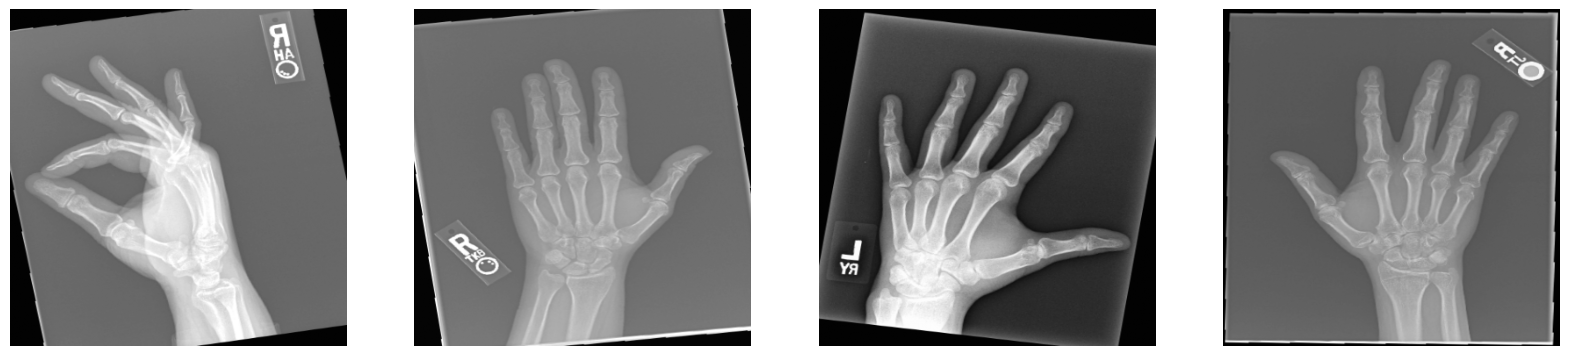

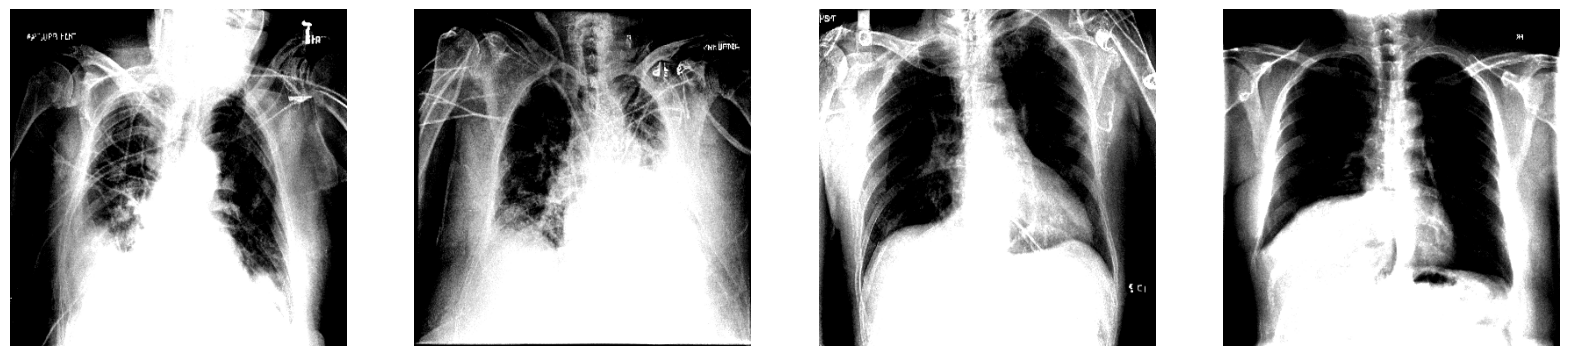

Epoch 1/5:   0%|          | 0/311 [00:31<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.12 GiB. GPU 0 has a total capacity of 44.42 GiB of which 378.50 MiB is free. Process 985403 has 11.01 GiB memory in use. Including non-PyTorch memory, this process has 33.03 GiB memory in use. Of the allocated memory 30.91 GiB is allocated by PyTorch, and 1.81 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [40]:
dataset_config = {
    "name": "mura",
    "root": "/home/hd/hd_hd/hd_gu452/MURA",
    "patchsize": None,
    "resize_to": 384,
    "to_grayscale": True,
    "augment": True,
    "normalization_type": "bounded",
}
train_ct_ddpm(dataset_config , load_pretrained_path="../CheXpert/diffusion-chexpert/epoch_5")


# Validation

In [4]:
from diffusers import UNet2DModel, DDPMScheduler, DPMSolverMultistepScheduler, FlowMatchEulerDiscreteScheduler
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = UNet2DModel.from_pretrained("diffusion-mura/epoch_9").to(device)
model.eval()

# Load scheduler (make sure it's consistent with training)
scheduler = DDPMScheduler(clip_sample=True, variance_type="fixed_large")
# Sampling config
num_inference_steps = 200  # Faster than training time
scheduler.set_timesteps(num_inference_steps)

# Sample shape: (B, C, H, W)
image_size = model.config.sample_size
batch_size = 4
samples = torch.randn((batch_size, 1, image_size, image_size)).to(device)

# Run reverse diffusion
with torch.no_grad():
    for t in scheduler.timesteps:
        # Predict noise
        noise_pred = model(samples, t).sample
        if torch.isnan(noise_pred).any():
            print(f"NaN in noise_pred at t={t}")
        # Denoise step
        samples = scheduler.step(noise_pred, t, samples).prev_sample

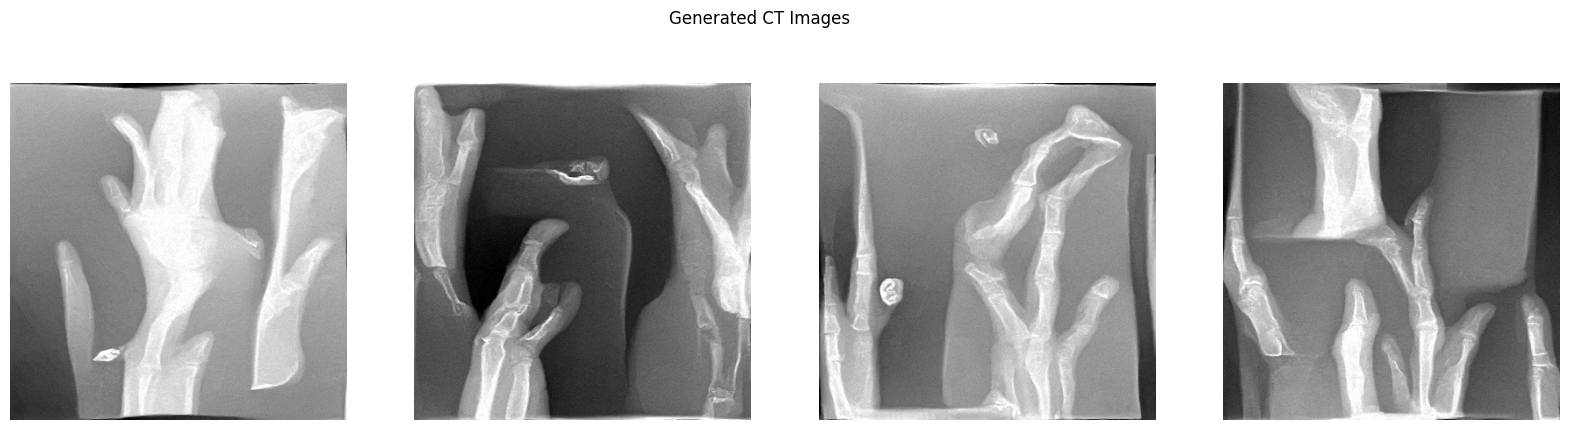

In [6]:
samples_norm = denormalize(samples, clamp=True)
samples_norm = samples_norm.cpu().numpy()
# normalize

# Plot
fig, axs = plt.subplots(1, batch_size, figsize=(20, 5))
for i in range(batch_size):
    axs[i].imshow(samples_norm[i].mean(axis=0), cmap="gray", vmin=0, vmax=1)
    axs[i].axis("off")
plt.suptitle("Generated CT Images")
plt.show()

In [7]:
samples.mean(), samples.std()

(tensor(0.0945, device='cuda:0'), tensor(0.4402, device='cuda:0'))

In [1]:
import matplotlib.pyplot as plt
from fff.data import load_dataset

dataset_config = {
    "name": "mura",
    "root": "/home/hd/hd_hd/hd_gu452/MURA",
    "patchsize": None,
    "resize_to": 384,
    "to_grayscale": True,
    "augment": True,
    "normalization_type": "data_mean",
    "percentile_clip": True,
    "invert_flipped_polarity": True,
}

train_ds, _, _ = load_dataset(**dataset_config)


INFO: Using pytorch backend
/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-12 12:42:05.479376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/gpfs/bwfor/home/hd

In [6]:
import torch

imgs = []
for i in range(100):
    imgs.append(train_ds[i])
imgs = torch.cat(imgs, dim=0)
imgs.mean(), imgs.std()

(tensor(-0.0030), tensor(1.0106))

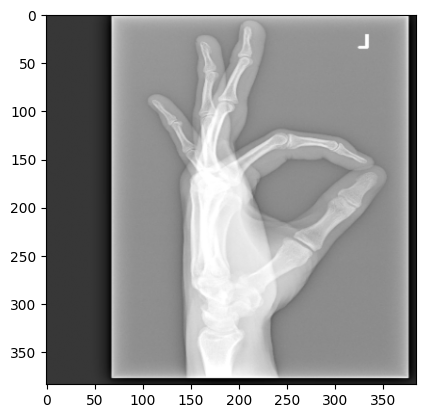

In [13]:
plt.imshow(train_ds.denormalize(train_ds[23]).cpu().detach().numpy().mean(axis=0), cmap="gray", vmin=0, vmax=1)
